[View in Colaboratory](https://colab.research.google.com/github/jpskycak/research_notebooks/blob/master/modeling_programmable_self_assembly_with_cellular_automata.ipynb)

In [0]:
class Agents:
  import numpy as np
  import matplotlib.pyplot as plt
  import itertools
  import random
  
  def distance((a,b),(x,y)):
    return max(abs(a-x),abs(b-y))
  def get_coordinates(array):
    return [(i,j) for i,row in enumerate(array) for j,val in enumerate(row) if val==1]
  
  def __init__(self,L=10,scale=5):
    self.grid_shape = (scale*L, scale*L)
    agents_array = np.zeros(self.grid_shape)
    agents_array[L:2*L,L:2*L] = 1
    template_array = np.zeros(self.grid_shape)
    template_array[2*L-1:3*L-1,2*L-1:3*L-1] = 1
    self.template_coordinates = get_coordinates(template_array)
    
    self.true_coordinates = get_coordinates(agents_array)
    self.estimated_coordinates = self.true_coordinates
    self.orientation = [(1,0) for _ in self.true_coordinates]
    self.update_neighbors()
    
    prod = [i*j for (i,j) in self.true_coordinates]
    maxprod = max(prod)
    self.is_source = [bool(p == maxprod) for p in prod]
    self.update_gradient()  
    self.log = []
    
  def get_neighbors(self,i):
    center = self.true_coordinates[i]
    return [j for j,p in enumerate(self.true_coordinates) if distance(center,p)==1 and i!=j]
  
  def plot(self,highlight=[]):
    grid = np.zeros(self.grid_shape)
    for p in self.template_coordinates:
      grid[p]=0.33
    #max_gradient = max(self.gradient)
    for i,p in enumerate(self.true_coordinates):
      grid[p] = 1#1+ 2*(1 - float(max_gradient - self.gradient[i])/max_gradient)
    for i in highlight:
      grid[self.true_coordinates[i]] = 2
    plt.imshow(grid)
    plt.grid(False)
    plt.show()
  
  def update_neighbors(self):
    self.neighbors = [self.get_neighbors(i) for i in range(len(self.true_coordinates))]
  
  def get_estimated_coordinates(self,i):
    neighbors_estimated_coordinates = [self.estimated_coordinates[j] for j in self.neighbors[i]]
    neighbors_estimated_coordinates_x = [p[0] for p in neighbors_estimated_coordinates]
    neighbors_estimated_coordinates_y = [p[1] for p in neighbors_estimated_coordinates]
    [min_x, max_x] = [min(neighbors_estimated_coordinates_x), max(neighbors_estimated_coordinates_x)]
    [min_y, max_y] = [min(neighbors_estimated_coordinates_y), max(neighbors_estimated_coordinates_y)]
    candidate_estimations = list(itertools.product(range(min_x-1,max_x+2),range(min_y-1,max_y+2)))
    
    def error_estimated_coordinates(p):
      errors = [1 - distance(p,p_neighbor) for p_neighbor in neighbors_estimated_coordinates]
      return sum([abs(err) for err in errors])
    
    candidate_estimation_errors = [error_estimated_coordinates(p) for p in candidate_estimations]
    optimal_estimations = [candidate_estimations[i] for i,err in enumerate(candidate_estimation_errors) if err==min(candidate_estimation_errors)]
    estimated_coordinates = random.choice(optimal_estimations)
    return estimated_coordinates
  
  def update_estimated_coordinates(self):
    self.estimated_coordinates = [self.get_estimated_coordinates(i) for i in range(len(self.true_coordinates))]
    
  def update_gradient(self):
    self.gradient = ['' for _ in self.true_coordinates]
    i_source = self.is_source.index(True)
    self.gradient[i_source] = 0
    for j in self.neighbors[i_source]:
      self.gradient[j] = 1
    while '' in self.gradient:
      for i,g in enumerate(self.gradient):
        if g=='':
          min_gradient_in_neighbors = 9*10**10
          should_assign_gradient_value = False
          for j in self.neighbors[i]:
            if self.gradient[j] != '':
              min_gradient_in_neighbors = min(self.gradient[j],min_gradient_in_neighbors)
              should_assign_gradient_value = True
          if should_assign_gradient_value:
            self.gradient[i] = 1+min_gradient_in_neighbors
    

  def can_move(self,i):
    ans = False
    (x0,y0) = self.true_coordinates[i]
    (dx,dy) = self.orientation[i]
    (x,y) = (x0+dx,y0+dy)
    occupied = [self.true_coordinates[j] for j in self.neighbors[i]]
    if (x,y) not in occupied:
      surroundings = [p for p in [(x+1,y),(x-1,y),(x,y+1),(x,y-1),(x-1,y-1),(x-1,y+1),(x+1,y-1),(x+1,y+1)] if p != (x0,y0)]
      if any([(p in occupied) for p in surroundings]): # doesn't break off from the mass
        if x in range(self.grid_shape[0]) and y in range(self.grid_shape[1]): # stays in grid
          if (x0,y0) not in self.template_coordinates or ((x0,y0) in self.template_coordinates and (x,y) in self.template_coordinates): # doesn't exit template
            ans = True
    return ans
  
  def move(self,i):
    def arrow(orientation):
      if orientation == (-1,0):
        return '⇡'
      elif orientation == (1,0):
        return '⇣'
      elif orientation == (0,-1):
        return '⇠'
      elif orientation == (0,1):
        return '⇢'
    def fill_log_turn(s):
      return s.format(i,self.true_coordinates[i],arrow((dx0,dy0)),' and '.join([arrow(t) for t in turns]),arrow(self.orientation[i]))
    def fill_log_edgefollow(s):
      return s.format(i,arrow(self.orientation[i]),(x0,y0),self.true_coordinates[i])
    
    if self.can_move(i): # edge-follow
      (x0,y0) = self.true_coordinates[i]
      (dx,dy) = self.orientation[i]
      self.true_coordinates[i] = (x0+dx,y0+dy)
      self.update_neighbors()
      self.update_estimated_coordinates()
      self.log.append(fill_log_edgefollow('Agent {0} moves in direction {1} from {2} to {3}.'))
    else: # turn
      (dx0,dy0) = self.orientation[i]
      turns = list(set([(-1,0),(0,1),(1,0),(0,-1)])-set([(-dx0,-dy0),(dx0,dy0)])) # can't go backwards
      admissible_turns = []
      for t in turns:
        self.orientation[i] = t
        if self.can_move(i):
          admissible_turns.append(t)
      if len(admissible_turns) == 0: # keep original orientation
        self.orientation[i] = (dx0,dy0)
        self.log.append(fill_log_turn('Agent {0} at {1} is unable to move in direction {2}. Of turns {3}, none are valid, so agent maintains direction {4}.'))
      elif len(admissible_turns) == 1: # turn
        self.orientation[i] = admissible_turns[0]
        self.log.append(fill_log_turn('Agent {0} at {1} is unable to move in direction {2}. Of turns {3}, only {4} is valid.'))
      elif len(admissible_turns) == 2: # turn in direction that gets closest to shape
        distance_to_template = []
        (x0,y0) = self.estimated_coordinates[i]
        for (dx,dy) in turns:
          (x,y) = (x0+dx,y0+dy)
          distance_to_template.append(min([distance((x,y),p) for p in self.template_coordinates]))
        if distance_to_template[0] > distance_to_template[1]:
          self.orientation[i] = turns[0]
          self.log.append(fill_log_turn('Agent {0} at {1} is unable to move in direction {2}. Both turns {3} are valid, but {4} is more optimal.'))
        elif distance_to_template[0] < distance_to_template[1]:
          self.orientation[i] = turns[1]
          self.log.append(fill_log_turn('Agent {0} at {1} is unable to move in direction {2}. Both turns {3} are valid, but {4} is more optimal.'))
        elif distance_to_template[0] == distance_to_template[1]:
          self.orientation[i] = random.choice(turns)
          self.log.append(fill_log_turn('Agent {0} at {1} is unable to move in direction {2}. Both turns {3} are valid and optimal, and {4} is randomly chosen.'))
 
  def timestep_forward(self):
    nonsurrounded_subset = [i for i,neighbor_list in enumerate(self.neighbors) if len(neighbor_list)<8]
    random.shuffle(nonsurrounded_subset)
    for i in nonsurrounded_subset:
      self.move(i)
      try:
        print self.log[-1]
      except:
        pass
      self.plot(highlight=[i])

Agent 80 at (18, 10) is unable to move in direction ⇣. Of turns ⇢ and ⇠, only ⇠ is valid.


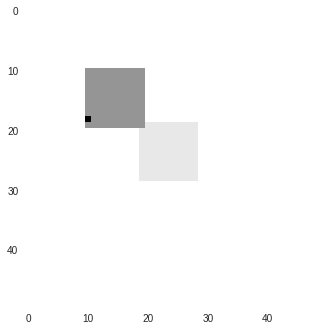

Agent 70 at (17, 10) is unable to move in direction ⇣. Of turns ⇢ and ⇠, only ⇠ is valid.


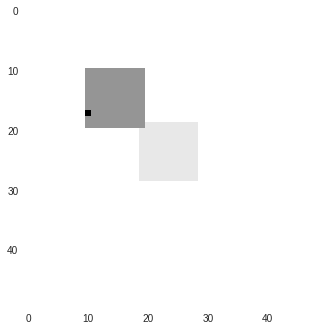

Agent 96 moves in direction ⇣ from (19, 16) to (20, 16).


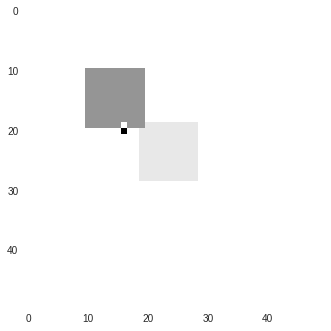

Agent 7 at (10, 17) is unable to move in direction ⇣. Of turns ⇢ and ⇠, none are valid, so agent maintains direction ⇣.


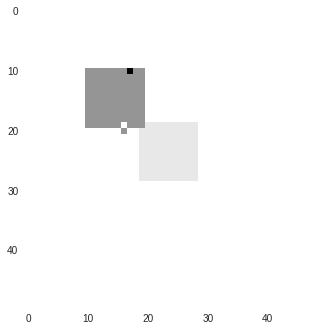

Agent 50 at (15, 10) is unable to move in direction ⇣. Of turns ⇢ and ⇠, only ⇠ is valid.


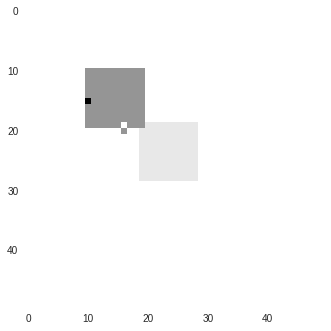

Agent 92 moves in direction ⇣ from (19, 12) to (20, 12).


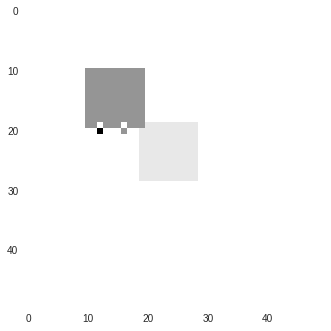

Agent 98 moves in direction ⇣ from (19, 18) to (20, 18).


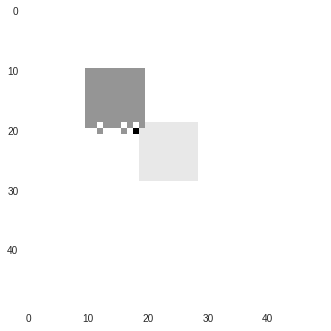

Agent 4 at (10, 14) is unable to move in direction ⇣. Of turns ⇢ and ⇠, none are valid, so agent maintains direction ⇣.


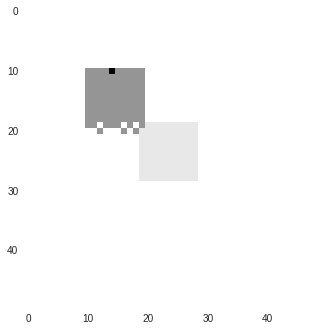

Agent 0 at (10, 10) is unable to move in direction ⇣. Of turns ⇢ and ⇠, only ⇠ is valid.


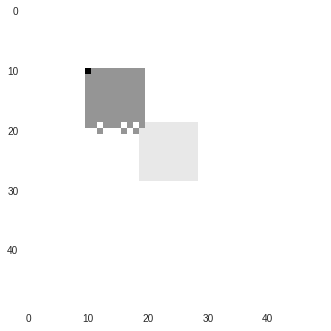

Agent 49 at (14, 19) is unable to move in direction ⇣. Of turns ⇢ and ⇠, only ⇢ is valid.


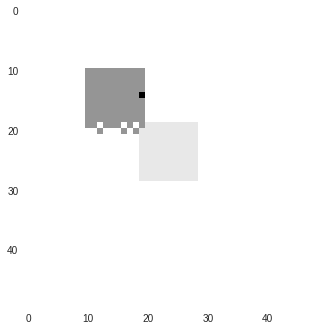

Agent 69 at (16, 19) is unable to move in direction ⇣. Of turns ⇢ and ⇠, only ⇢ is valid.


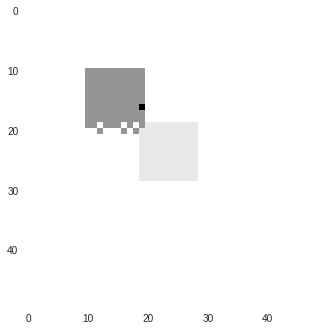

Agent 10 at (11, 10) is unable to move in direction ⇣. Of turns ⇢ and ⇠, only ⇠ is valid.


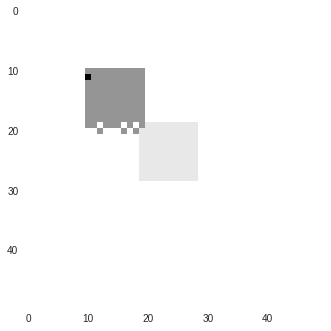

Agent 59 at (15, 19) is unable to move in direction ⇣. Of turns ⇢ and ⇠, only ⇢ is valid.


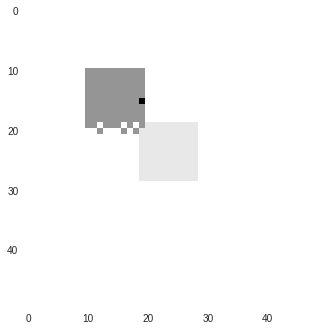

Agent 89 at (18, 19) is unable to move in direction ⇣. Of turns ⇢ and ⇠, only ⇢ is valid.


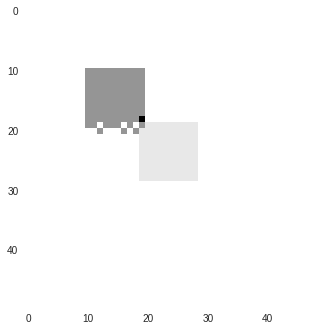

Agent 99 moves in direction ⇣ from (19, 19) to (20, 19).


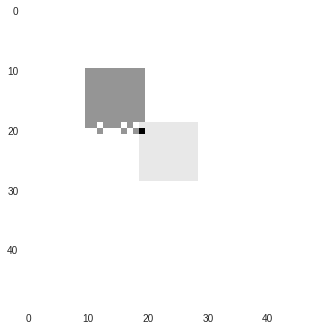

Agent 30 at (13, 10) is unable to move in direction ⇣. Of turns ⇢ and ⇠, only ⇠ is valid.


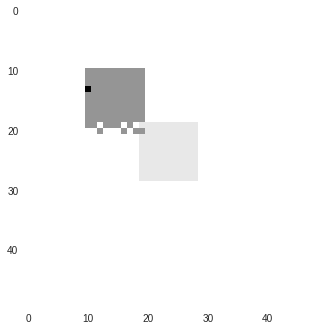

Agent 40 at (14, 10) is unable to move in direction ⇣. Of turns ⇢ and ⇠, only ⇠ is valid.


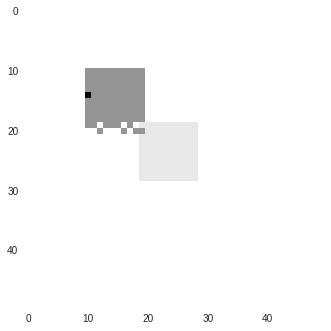

Agent 97 moves in direction ⇣ from (19, 17) to (20, 17).


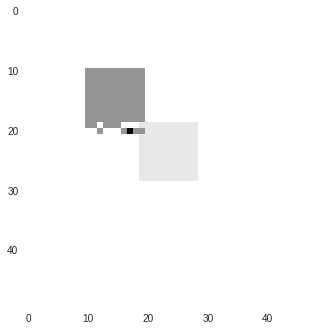

Agent 3 at (10, 13) is unable to move in direction ⇣. Of turns ⇢ and ⇠, none are valid, so agent maintains direction ⇣.


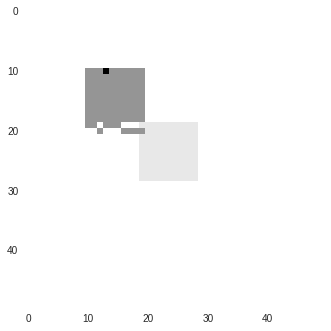

Agent 5 at (10, 15) is unable to move in direction ⇣. Of turns ⇢ and ⇠, none are valid, so agent maintains direction ⇣.


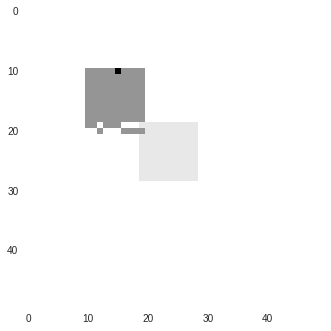

Agent 6 at (10, 16) is unable to move in direction ⇣. Of turns ⇢ and ⇠, none are valid, so agent maintains direction ⇣.


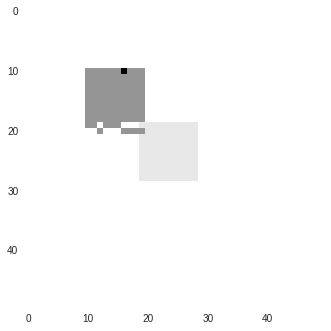

Agent 91 moves in direction ⇣ from (19, 11) to (20, 11).


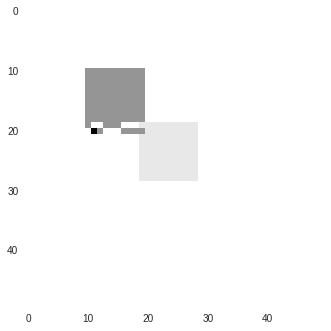

Agent 8 at (10, 18) is unable to move in direction ⇣. Of turns ⇢ and ⇠, none are valid, so agent maintains direction ⇣.


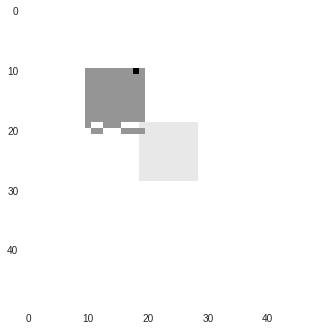

Agent 93 moves in direction ⇣ from (19, 13) to (20, 13).


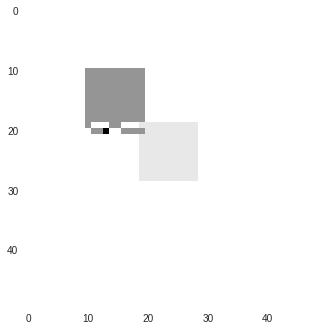

Agent 60 at (16, 10) is unable to move in direction ⇣. Of turns ⇢ and ⇠, only ⇠ is valid.


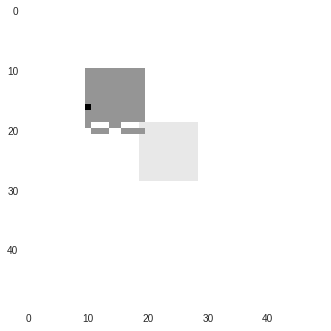

Agent 2 at (10, 12) is unable to move in direction ⇣. Of turns ⇢ and ⇠, none are valid, so agent maintains direction ⇣.


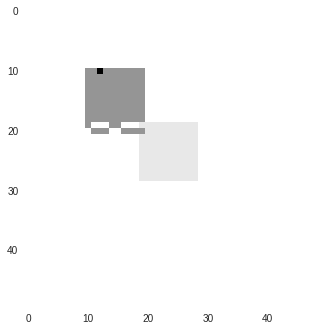

Agent 90 moves in direction ⇣ from (19, 10) to (20, 10).


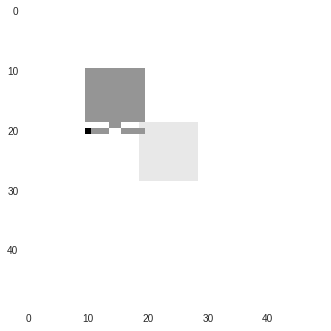

Agent 20 at (12, 10) is unable to move in direction ⇣. Of turns ⇢ and ⇠, only ⇠ is valid.


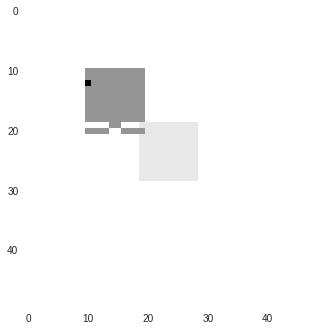

Agent 29 at (12, 19) is unable to move in direction ⇣. Of turns ⇢ and ⇠, only ⇢ is valid.


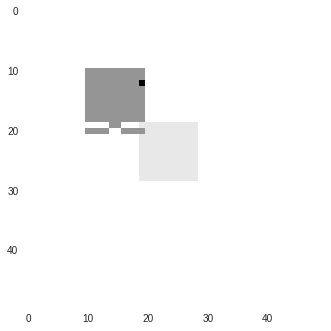

Agent 95 moves in direction ⇣ from (19, 15) to (20, 15).


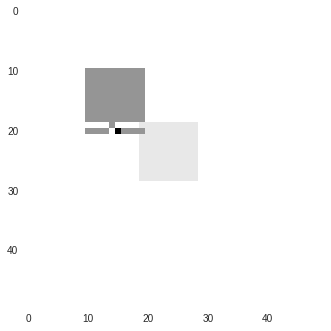

Agent 79 at (17, 19) is unable to move in direction ⇣. Of turns ⇢ and ⇠, only ⇢ is valid.


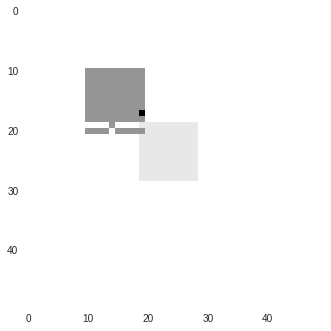

Agent 39 at (13, 19) is unable to move in direction ⇣. Of turns ⇢ and ⇠, only ⇢ is valid.


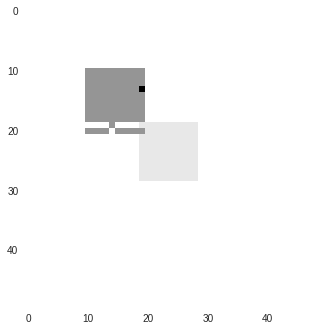

Agent 1 at (10, 11) is unable to move in direction ⇣. Of turns ⇢ and ⇠, none are valid, so agent maintains direction ⇣.


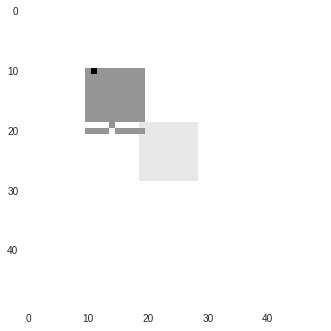

Agent 94 moves in direction ⇣ from (19, 14) to (20, 14).


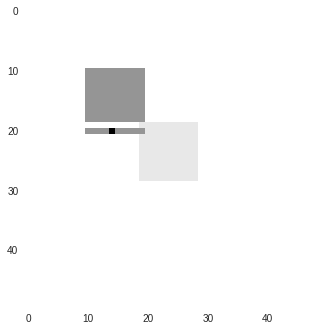

Agent 9 at (10, 19) is unable to move in direction ⇣. Of turns ⇢ and ⇠, only ⇢ is valid.


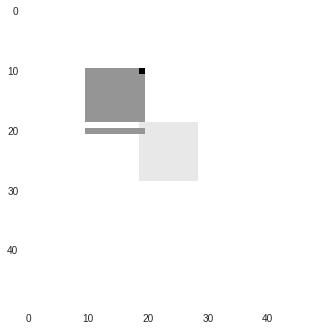

Agent 19 at (11, 19) is unable to move in direction ⇣. Of turns ⇢ and ⇠, only ⇢ is valid.


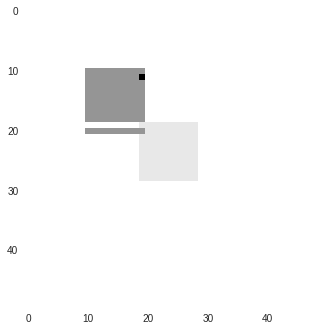

In [189]:
a = Agents()
a.timestep_forward()